# CC Scheme

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from obspy import UTCDateTime, read_inventory
import xcorr

In [2]:
%matplotlib notebook

In [3]:
client = xcorr.Client(sds_root='/Users/psmets/Documents/Research/_data/WaveformArchive')

In [4]:
inv = read_inventory('../data/Monowai_new.xml')

<IPython.core.display.Javascript object>


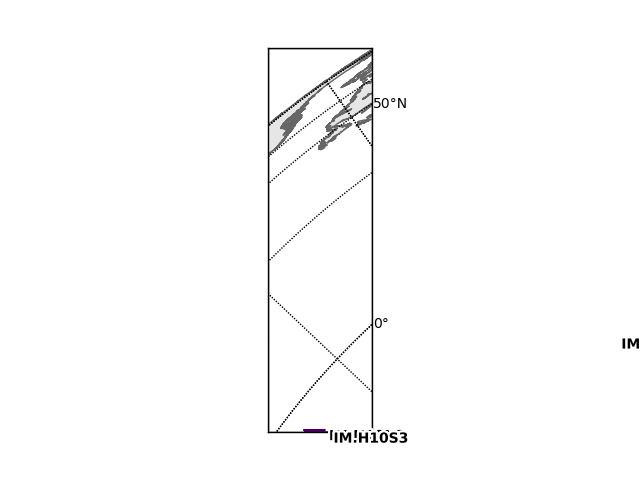

In [5]:
fig = inv.plot(color=0., projection='local')

<IPython.core.display.Javascript object>


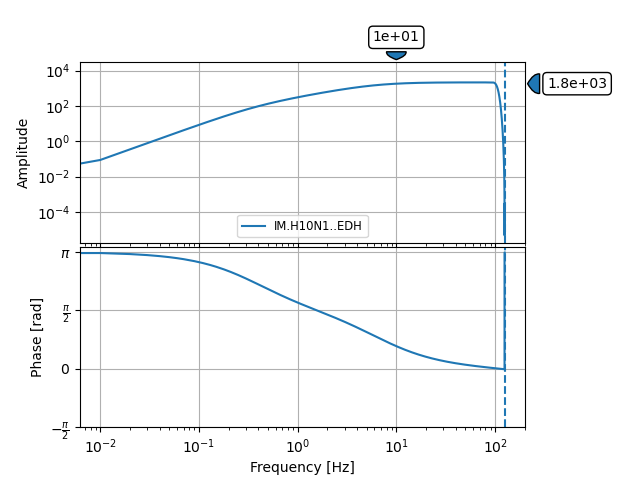

In [8]:
fig = inv.plot_response(0.01, station="H10N1")

## Get waveforms

In [7]:
EDH = client.get_waveforms(
    receiver = 'IM.H10N1..EDH', 
    time = pd.to_datetime('2015-01-15T12:00'), 
    verb = True,
)

Get waveforms for IM.H10N1..EDH from 2015-01-14 23:59:00 until 2015-01-16 00:01:00


In [ ]:
f = EDH.plot()

## Preprocess settings

In [9]:
# stream preprocess operations (sequential!)
preprocess = {
    'BHZ': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
    ],
    'BHR': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('rotate', {'method':'->ZNE'}),
        ('rotate', {'method':'NE->RT', 'back_azimuth':250.39 }),
        ('select', {'channel':'BHR'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
    ],
    'EDH': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {}),
        ('filter', { 'type': 'bandpass', 'freqmin': 3., 'freqmax': 20. }),
        ('decimate', { 'factor': 5 }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
    ],
}

In [ ]:
H10 = client.get_preprocessed_waveforms(
    receiver = 'IM.H10N1..EDH', 
    time = pd.to_datetime('2015-01-15T12:00'), 
    preprocess = preprocess,
    inventory = inv,
    verb = 0,
)

In [ ]:
f = H10.plot()

In [ ]:
H03 = client.get_preprocessed_waveforms(
    receiver = 'IM.H03S1..EDH', 
    time = pd.to_datetime('2015-01-15T12:00'), 
    preprocess = preprocess,
    inventory = inv,
    verb = 0,
)

In [ ]:
f = H03.plot()

In [ ]:
BHZ = client.get_preprocessed_waveforms(
    receiver = 'IU.RAR.10.BHZ', 
    time = pd.to_datetime('2015-01-15T12:00'), 
    preprocess = preprocess,
    inventory = inv,
    verb = True,
)

In [ ]:
BHZ.plot()

In [ ]:
BHR = client.get_preprocessed_waveforms(
    receiver = 'IU.RAR.10.BHR', 
    time = pd.to_datetime('2016-01-15T12:00'), 
    preprocess = preprocess,
    inventory = inv,
    verb = 2,
)

In [ ]:
BHR.plot()

## Preprocessed pair stream

In [ ]:
pair = client.get_pair_preprocessed_waveforms(
    pair = 'IM.H03S1..EDH-IU.RAR.10.BHZ',
    time = pd.to_datetime('2015-01-15T12:00'), 
    preprocess = preprocess,
    inventory = inv,
    verb = 2,
)

In [ ]:
pair[0].plot()

In [ ]:
pair[1].plot()

## Hash

In [ ]:
%%timeit
xcorr.util.hasher.hash_Stream(pair)

In [ ]:
xcorr.util.hasher.hash(pair)

# Verify data availability

In [ ]:
pairs = [
    'IM.H10N1..EDH-IU.RAR.10.BHZ',
    'IM.H10N1..EDH-IU.RAR.10.BHR',
    'IM.H03S1..EDH-IU.RAR.10.BHZ',
    'IM.H03S1..EDH-IU.RAR.10.BHR',
]
times = pd.date_range('2014-12-31', '2015-02-01', freq='1D')

In [ ]:
status = client.data_availability(pairs, times, verb=2, download=False)

In [ ]:
status

Or in separate steps to control dask delayed compute:

In [ ]:
status = client.init_data_availability(pairs, times)
delayed_status = client.verify_data_availability(status, download=False, compute=False)

In [ ]:
status.receiver

In [ ]:
delayed_status.visualize()

In [ ]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    verified = delayed_status.compute()

In [ ]:
status